In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.definitions import compute
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
import polars as pl
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Future som stuff

In [2]:
ds_cesm = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/ds.zarr", engine="zarr")
ds_cesm = ds_cesm.chunk({"member": 1, "time": 100, "lat": -1, "lon": -1})
da_cesm = ds_cesm["s"].sel(time=ds_cesm.time.dt.season=="JJA")
dh = DataHandler("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/results/2", da_cesm)
exp_s_cesm = Experiment(dh)

In [3]:
kwargs_som = dict(
    nx=6,
    ny=6,
    activation_distance="euclidean",
    PBC=True,
    init="pca",
    return_type=RAW_REALSPACE,
    sigma=2,
    sigmaN=0.1,
    dask_chunks=(500, -1),
    train_kwargs=dict(num_epochs=20),
)
net, centers, labels = exp_s_cesm.som_cluster(**kwargs_som)
nx, ny, metric = kwargs_som["nx"], kwargs_som["ny"], kwargs_som["activation_distance"]
ds_center_path = exp_s_cesm.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
ds_ = ds_cesm.sel(time=ds_cesm.time.dt.season=="JJA")
if not ds_center_path.is_file():
    ds_ = _compute(ds_, progress=True)
    ds_center = labels_to_centers(labels, ds_)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={**determine_sample_dims(ds_), "cluster": np.arange(net.n_nodes)})

# composites

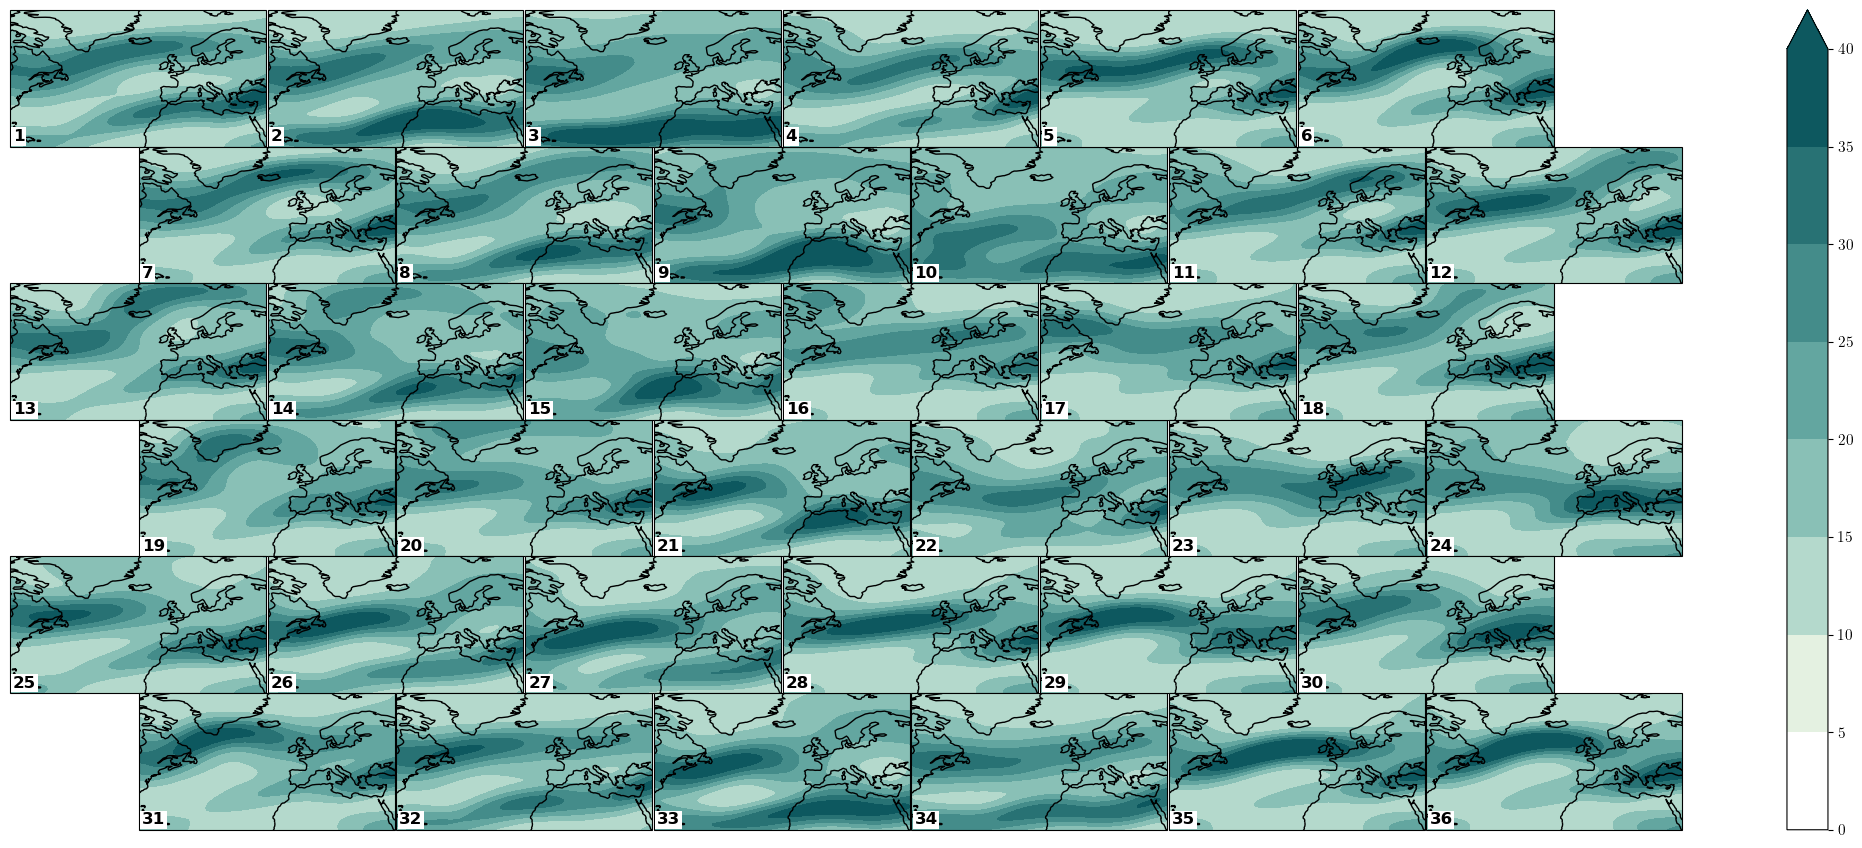

In [7]:
clu = Clusterplot(kwargs_som["nx"], kwargs_som["ny"], honeycomb=True, numbering=np.arange(1, 37).tolist(), region=get_region(ds_center))
_ = clu.add_contourf(ds_center["s"], cmap=colormaps.mint, transparify=1, levels=8)

100%|██████████| 36/36 [00:00<00:00, 628.01it/s]


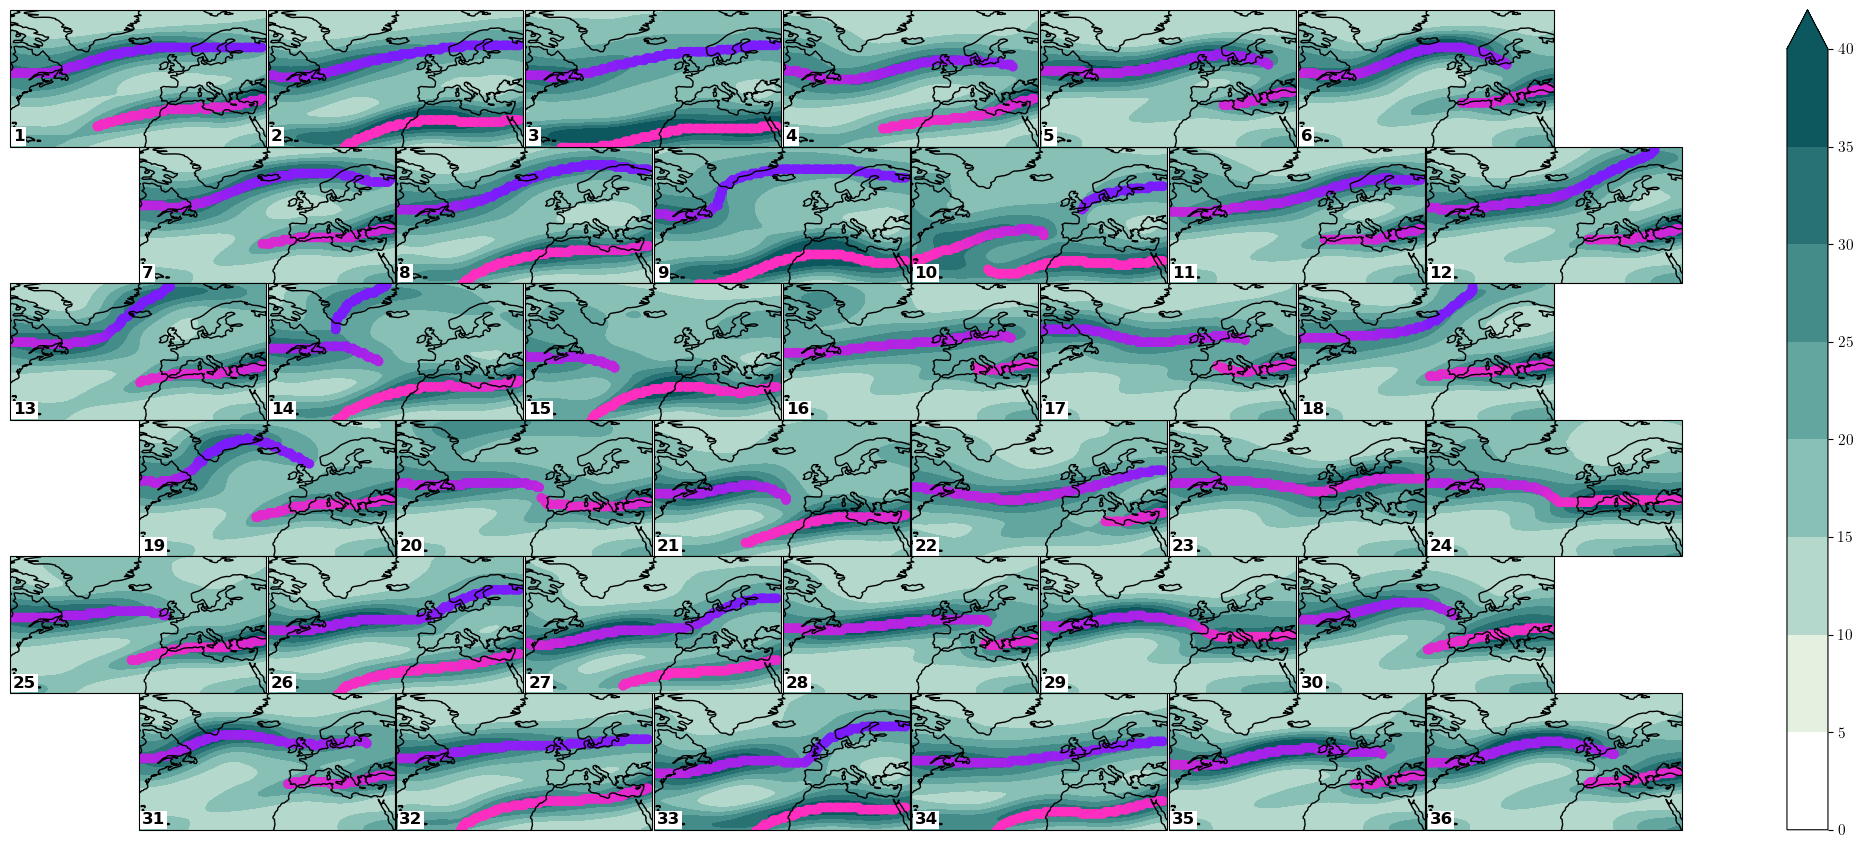

In [8]:
clu = Clusterplot(kwargs_som["nx"], kwargs_som["ny"], honeycomb=True, numbering=np.arange(1, 37).tolist(), region=get_region(ds_center))
_ = clu.add_contourf(ds_center["s"], cmap=colormaps.mint, transparify=1, levels=8)
jets_center = find_all_jets(xarray_to_polars(ds_center), base_s_thresh=20, alignment_thresh=0.4)
norm = Normalize(jets_center["lev"].quantile(0.1), jets_center["lev"].quantile(0.9))
cmap = PINKPURPLE
for i, jets in jets_center.group_by("cluster", maintain_order=True):
    for _, jet in jets.group_by("jet ID", maintain_order=True):
        x, y, lev = jet[["lon", "lat", "lev"]].to_numpy().T
        clu.axes[i[0]].scatter(x, y, c=lev, norm=norm, cmap=cmap)

# pathway

### overall

In [34]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    these_labels = labels.isel(time=group).values.flatten()
    coords = net.neighborhoods.coordinates[these_labels]
    unique, count = np.unique(these_labels, return_counts=True)
    
    timestepwise.append((unique, count))
    group = []

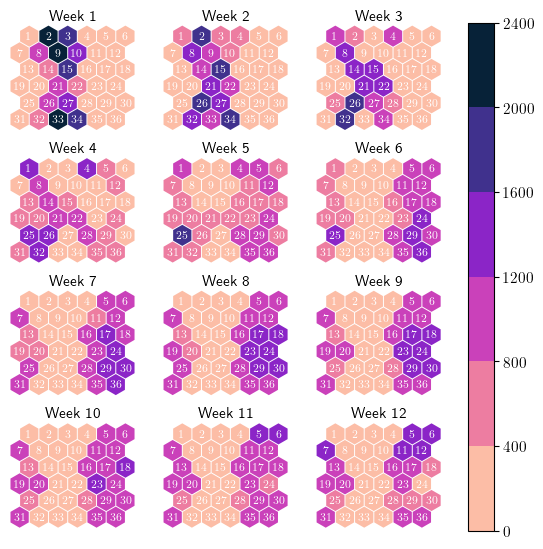

In [35]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 6.6), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 2401, 400), cmap.N)
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
fig.colorbar(im, ax=axes)
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    unique, counts = timestepwise[step][0], timestepwise[step][1]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/future_som_props/weekly_pathway.png")

### past

In [28]:
timestepwise = []
group = [] 
labels_past = labels.isel(time=labels.time.dt.year < 2020)
for i, (_, group_) in enumerate(labels_past.groupby(labels_past.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    these_labels = labels_past.isel(time=group).values.flatten()
    coords = net.neighborhoods.coordinates[these_labels]
    unique, count = np.unique(these_labels, return_counts=True)
    
    timestepwise.append((unique, count))
    group = []

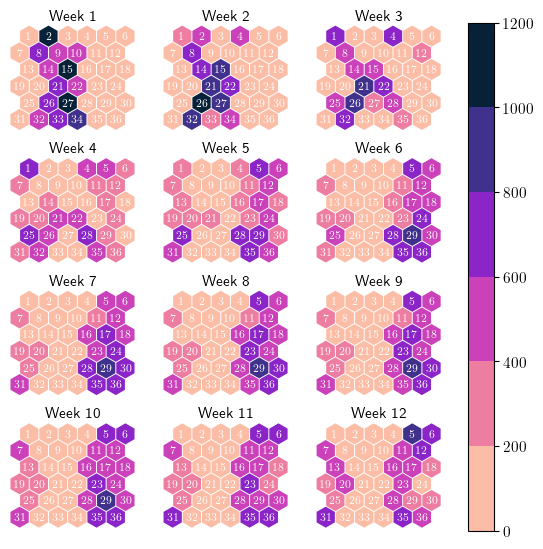

In [31]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 6.6), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 1201, 200), cmap.N)
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
fig.colorbar(im, ax=axes)
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    unique, counts = timestepwise[step][0], timestepwise[step][1]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/future_som_props/weekly_pathway_past.png")

### future

In [36]:
timestepwise = []
group = [] 
labels_future = labels.isel(time=labels.time.dt.year >= 2020)
for i, (_, group_) in enumerate(labels_future.groupby(labels_future.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    these_labels = labels_future.isel(time=group).values.flatten()
    coords = net.neighborhoods.coordinates[these_labels]
    unique, count = np.unique(these_labels, return_counts=True)
    
    timestepwise.append((unique, count))
    group = []

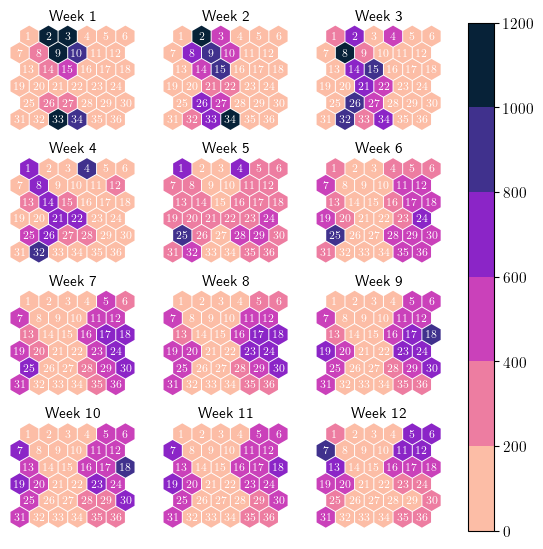

In [37]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 6.6), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 1201, 200), cmap.N)
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
fig.colorbar(im, ax=axes)
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    unique, counts = timestepwise[step][0], timestepwise[step][1]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/future_som_props/weekly_pathway_future.png")

## pops, trends